# Deep Convolutional Neural Networks


**Zadanie 1**: Dodać normalizację danych i następujące rozszerzenia zbioru treningowego:
- losowe odbicie lustrzane,
- losowy obrót o 10 stopni.

Uwaga: należy pamiętać o zamianie obrazów PIL na tensory.


Files already downloaded and verified


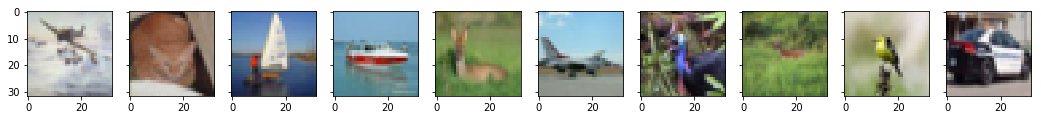

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


# średnia i odchylenie standardowe danych treningowych policzone dla 3 kanałów
mean = (0.49139968,  0.48215841,  0.44653091)
std = (0.24703223,  0.24348513,  0.26158784)

# wstępne przetwarzanie danych - normalizacja
transforms = tv.transforms.Compose([
   tv.transforms.ToTensor(),
   tv.transforms.Normalize(mean, std),
])

# preprocessing + augmentacja
transforms_with_augmentation = tv.transforms.Compose([
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(degrees=10),
    transforms
])

# dane treningowe są dodatkowo rozszerzone o losowe transformacje
# dane testowe nie podlegają rozszerzeniu, aby zachować powtarzalność wyników
train_dataset = tv.datasets.CIFAR10('.', train=True, transform=transforms_with_augmentation, download=True)
test_dataset = tv.datasets.CIFAR10('.', train=False, transform=transforms)

# wyświetlenie 10 losowych zdjęć ze zbioru danych
f, ax = plt.subplots(1, 10, sharex='col', sharey='row', figsize=(18, 16))
for a in ax:
    a.imshow(train_dataset.data[np.random.randint(len(train_dataset))])
plt.show()


In [2]:
from utils import show_results, ModelTrainer


class BaseBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(BaseBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels
            
        # konwolucja zawiera padding=1, aby nie zmniejszać rozmiaru obrazu
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        # istnieje wersja batch normalization dla obrazów - statystyki dla filtrów
        self.batch_norm1 = torch.nn.BatchNorm2d(hidden_channels)
        # nieliniowość ReLU
        self.relu1 = torch.nn.ReLU()
        
        # drugi raz te same warstwy
        self.conv2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()
    
    def forward(self, x):
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.relu2(self.batch_norm2(self.conv2(out)))
        return out

    
class ConvNet(torch.nn.Module):
    
    def __init__(self, block):
        super(ConvNet, self).__init__()
        
        # wstępna warstwa konwolucyjna + ReLU
        self.conv = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU()
        
        # (mikroarchitektura + max pooling) x 2
        self.block1 = block(16, 32)
        self.pool1 = torch.nn.MaxPool2d(2)
        self.block2 = block(32, 32)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        # warstwa w pełni połączona po "rozprostowaniu" obrazu do postaci wektora
        self.dense = torch.nn.Linear(8 * 8 * 32, 10)
    
    def forward(self, x):
        out = self.relu(self.conv(x))
        out = self.block1(out)
        out = self.pool1(out)
        out = self.block2(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        return self.dense(out)


def run_model(model, n_epochs):
    trainer = ModelTrainer(train_dataset, test_dataset, batch_size=256)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    history = trainer.train(model, optimizer, n_epochs=n_epochs)
    show_results(model=history)
    n_parameters = sum([np.prod(p.size()) for p in model.parameters()])
    print("Number of parameters:", n_parameters)


base_model = ConvNet(BaseBlock)

100%|██████████| 3/3 [27:53<00:00, 555.51s/it]


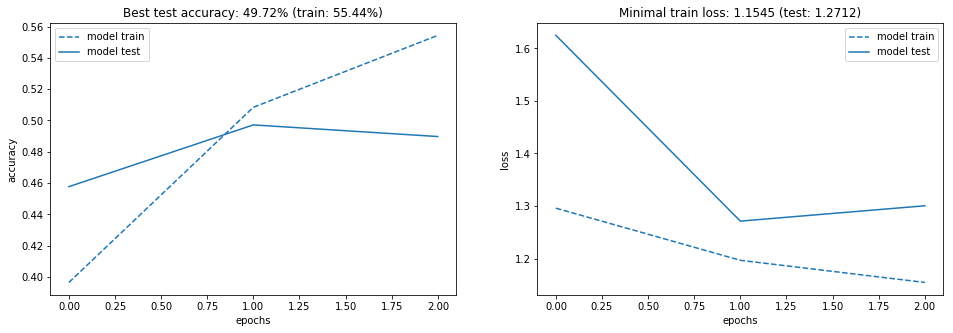

Number of parameters: 53578


In [3]:

run_model(base_model, n_epochs=3)

In [4]:
# import sys
# !conda install --yes --prefix {sys.prefix} graphviz
# !conda install --yes --prefix {sys.prefix} python-graphviz
# !{sys.executable} -m pip install torchviz

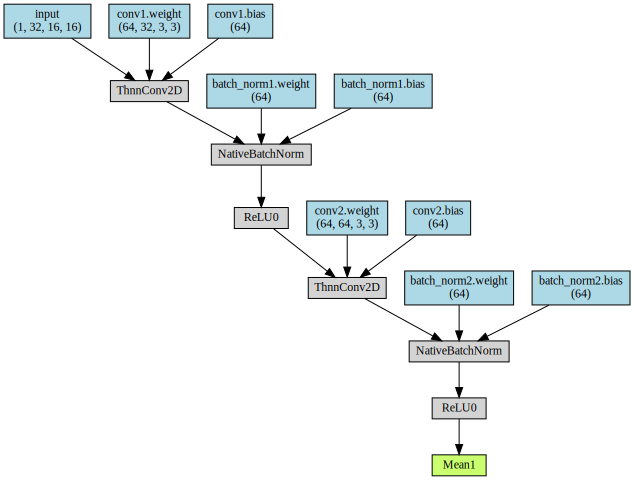

In [5]:
from torchviz import make_dot

def vizualize_block(block, input_shape=(1, 32, 16, 16), output_channels=64):
    model = block(input_shape[1], output_channels)
    x = torch.randn(input_shape).requires_grad_(True)
    y = model(x)
    g = make_dot(y.mean(), params=dict(list(model.named_parameters()) + [('input', x)]))
    g.body = [v.replace('Backward', '').replace('Threshold', 'ReLU') for v in g.body]
    return g

vizualize_block(BaseBlock)

### I. ResNet

**Zadanie 2**: Zaimplementować blok rezydualny architektury ResNet.

1. Moduł ma zawierać **2 konwolucje 3x3 o `hidden_channels` filtrach** z **batch normalization** i nieliniowością **ReLU** pomiędzy nimi.
2. Dodane powinno zostać **połączenie skrótowe**, które dodaje wejście modułu do wyniku drugiej konwolucji.
3. Do wyniku dodawania powinna być dodana **warstwa batch norm i druga operacja ReLU**.

Uwaga: aby operacja dodawania była wykonywalna w przypadku `in_channels` < `out_channels`, należy dodać padding zerami do wejścia lub użyć konwolucji 1x1 o `out_channels` filtrach. Oba te podejścia są rozważane przez autorów ResNeta.

In [6]:
class ResNetBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(ResNetBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels
        self.conv_0 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv_1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.bn_1 = torch.nn.BatchNorm2d(hidden_channels)       
        self.conv_2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)
        self.bn_2 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x_tmp = self.conv_0(x)
        out = self.conv_1(x)
        out = self.bn_1(out)
        out = self.relu(out)
        out = self.conv_2(out)       
        out += x_tmp
        out = self.bn_2(out)
        out = self.relu(out)
        return out


resnet_model = ConvNet(ResNetBlock)


100%|██████████| 3/3 [28:47<00:00, 571.69s/it]


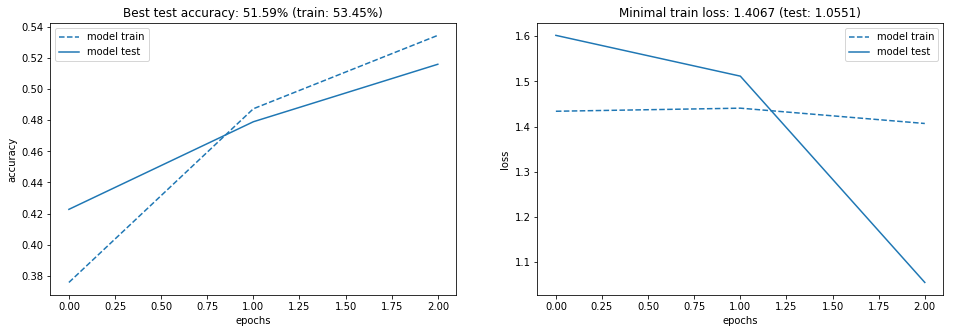

Number of parameters: 55114


In [7]:
run_model(resnet_model, n_epochs=3)

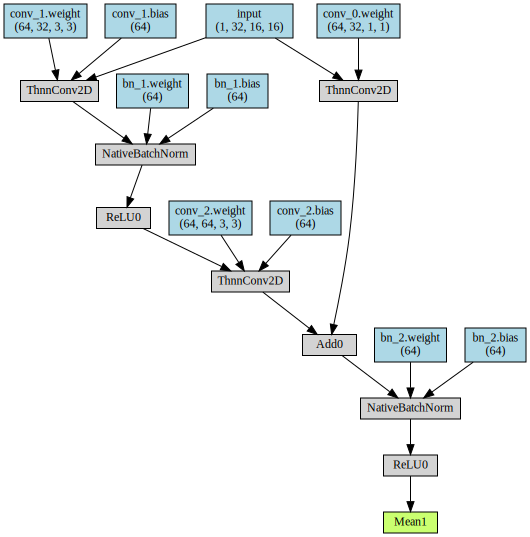

In [8]:
vizualize_block(ResNetBlock)

### II. SqueezeNet


**Zadanie 3**: Zaimplementować Fire Module z architektury SqueezeNet:

1. Pierwsza warstwa bloku (squeeze) zawiera **konwolucję 1x1 o `hidden_channels` filtrach, batch normalization i ReLU**.
2. Wyjście z pierwszej warstwy jest wejściem do dwóch **warstw konwolucyjnych 1x1 i 3x3** (expand). Całkowita liczba ich filtrów to w sumie `out_channels`.
3. Wyjścia są **łączone wzdłuż filtrów**, stosowane jest **batch normalization i ReLU**.

In [9]:
class SqueezeNetBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=8):
        super(SqueezeNetBlock, self).__init__()
        self.layer_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=1),
            torch.nn.BatchNorm2d(hidden_channels),
            torch.nn.ReLU()
        )
        self.conv_2_1 = torch.nn.Conv2d(hidden_channels, out_channels//2, kernel_size=1)
        self.conv_2_2 = torch.nn.Conv2d(hidden_channels, out_channels-out_channels//2, kernel_size=3, padding=1)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        out_1 = self.layer_1(x)
        out_2_1 = self.conv_2_1(out_1)
        out_2_2 = self.conv_2_2(out_1)
        out_3 = torch.cat([out_2_1, out_2_2], 1)
        out = self.bn(out_3)
        out = self.relu(out)
        return out

    
squeezenet_model = ConvNet(SqueezeNetBlock)

100%|██████████| 3/3 [15:45<00:00, 316.21s/it]


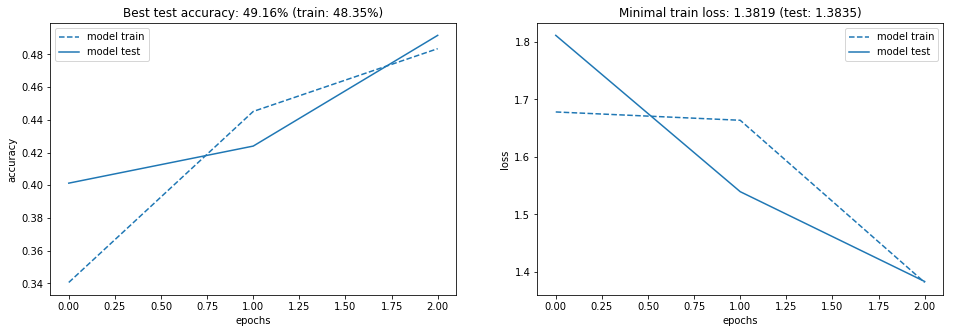

Number of parameters: 24122


In [10]:
run_model(squeezenet_model, n_epochs=3)


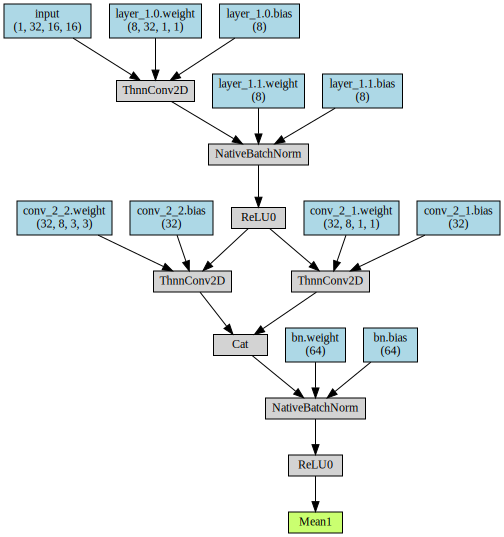

In [11]:
vizualize_block(SqueezeNetBlock)